In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint
import matplotlib.pyplot as plt

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
# load data
df = pd.read_csv('customer_booking.csv', encoding='latin1')

# encode categorical variables
for x in ['sales_channel', 'trip_type', 'flight_day']:
    for i in df[x].unique()[:-1]:
        df[i] = df[x].map({i:1})
        df.fillna({i:0}, inplace=True)
    df.drop(x, axis=1, inplace=True)

# drop columns for more explainable model
df.drop(['route', 'booking_origin'], axis=1, inplace=True)

df

num_passengers  purchase_lead  length_of_stay  flight_hour  \
0                   2            262              19            7   
1                   1            112              20            3   
2                   2            243              22           17   
3                   1             96              31            4   
4                   2             68              22           15   
...               ...            ...             ...          ...   
49995               2             27               6            9   
49996               1            111               6            4   
49997               1             24               6           22   
49998               1             15               6           11   
49999               1             19               6           10   

       wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
0                        1                     0                      0   
1                        0                     0                      0   
2                        1                     1                      0   
3                        0                     0                      1   
4                        1                     0                      1   
...                    ...                   ...                    ...   
49995                    1                     0                      1   
49996                    0                     0                      0   
49997                    0                     0                      1   
49998                    1                     0                      1   
49999                    0                     1                      0   

       flight_duration  booking_complete  Internet  RoundTrip  CircleTrip  \
0                 5.52                 0       1.0        1.0         0.0   
1                 5.52                 0       1.0        1.0         0.0   
2                 5.52                 0       1.0        1.0         0.0   
3                 5.52                 0       1.0        1.0         0.0   
4                 5.52                 0       1.0        1.0         0.0   
...                ...               ...       ...        ...         ...   
49995             5.62                 0       1.0        1.0         0.0   
49996             5.62                 0       1.0        1.0         0.0   
49997             5.62                 0       1.0        1.0         0.0   
49998             5.62                 0       1.0        1.0         0.0   
49999             5.62                 0       1.0        1.0         0.0   

       Sat  Wed  Thu  Mon  Sun  Tue  
0      1.0  0.0  0.0  0.0  0.0  0.0  
1      1.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  1.0  0.0  0.0  0.0  0.0  
3      1.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  1.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  
49995  1.0  0.0  0.0  0.0  0.0  0.0  
49996  0.0  0.0  0.0  0.0  1.0  0.0  
49997  1.0  0.0  0.0  0.0  0.0  0.0  
49998  0.0  0.0  0.0  1.0  0.0  0.0  
49999  0.0  0.0  1.0  0.0  0.0  0.0  

[50000 rows x 18 columns]

In [3]:
# split data
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Labels
Y_train = X_train['booking_complete']
X_train = X_train.drop('booking_complete', axis=1)

Y_test = X_test['booking_complete']
X_test = X_test.drop('booking_complete', axis=1)

In [4]:
# Find best hyperparameters and train model
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
forest = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(forest, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, Y_train)

# Create a variable for the best model
forest = rand_search.best_estimator_
Y_predictions = forest.predict(X_test)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 467}


In [5]:
# Train model
# forest = RandomForestClassifier(max_depth=len(X_train.columns), random_state=42)
# forest.fit(X_train, Y_train)
# Y_predictions = forest.predict(X_test)

In [6]:
# test model
accuracy = accuracy_score(Y_test, Y_predictions)
precision = precision_score(Y_test, Y_predictions)
recall = recall_score(Y_test, Y_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8536
Precision: 0.6904761904761905
Recall: 0.019594594594594596


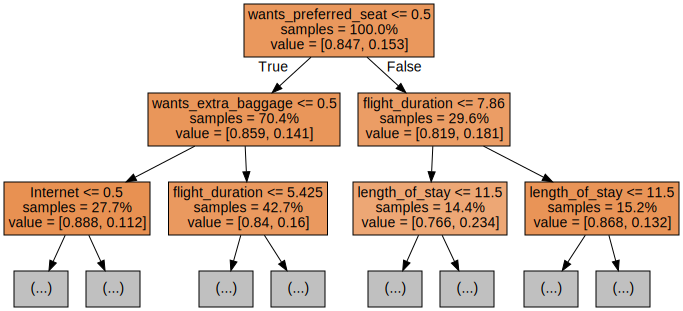

In [ ]:
# Plot tree
for i in range(1):
    tree = forest.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)
    # graph.render('tree', format='jpg', cleanup=True)

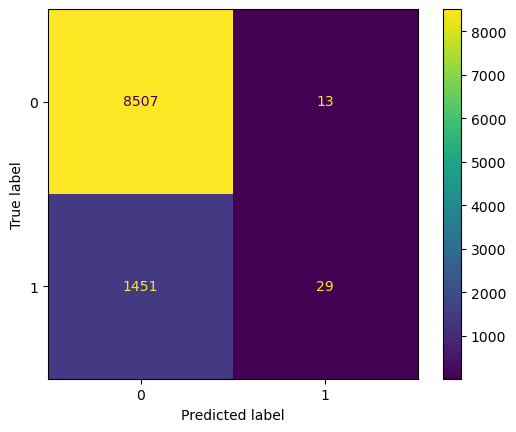

In [ ]:
# Confusion matrix
cm = confusion_matrix(Y_test, Y_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
# disp.figure_.savefig('confusion_matrix.png', transparent=True)

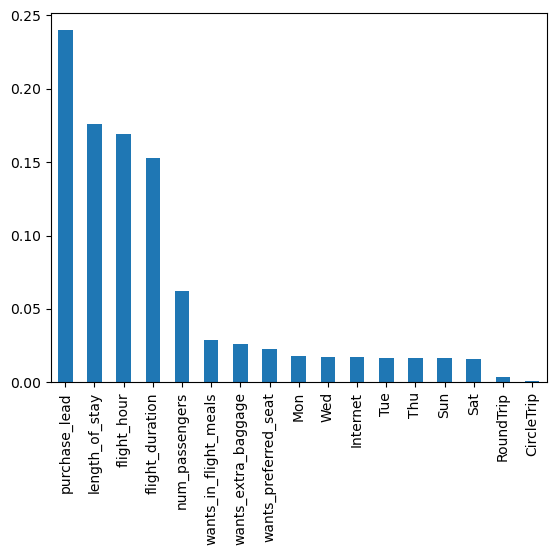

In [ ]:
# Feature importance
feature_importances = pd.Series(forest.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
# plt.savefig('output.png', transparent=True, bbox_inches='tight')